In [1]:
%reload_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# import tie.dbutils as db
import pandas as pd
from scipy.io import savemat, loadmat
import json
import os
from tqdm import notebook
from collections import Counter
import numpy as np
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.cluster import AgglomerativeClustering
from joblib import dump, load
import itertools
from sklearn.neighbors import KernelDensity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle as pkl

from matplotlib.gridspec import GridSpec
from scipy.stats import entropy
from xgboost import cv
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle as pkl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy
import datetime

from scipy.io import loadmat
from scipy.stats import zscore
np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

import matplotlib.style
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns

# rc('font', **{'family':'sans-serif',
#               'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)

In [28]:
def plot_JID(JID, ax, mask=None, color_bar_text="PD", cmap=matplotlib.cm.RdGy_r, vmin=None, vmax=None):
    labels = ['0.03', '0.1', '1', '4', '20']
    ticks = np.arange(50)[::10]
    im = ax.imshow(JID, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

    cmap.set_bad('white',1.)
    
    if mask is not None:
        ax.imshow(mask, 'gray_r', interpolation='none', alpha=0.2, vmin=vmin, vmax=vmax)
    ax.invert_yaxis()
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    ax.set_ylabel(r'$ITI(k + 1)$ [s]')
    ax.set_xlabel(r'$ITI(k)$ [s]')
    ax.text(-9, 50.5, color_bar_text, size=25)
    ax.grid(False)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    
def find_closest(x, a):
    return np.argmin(np.abs(x - a)) + 1

# Figure 1

## Panel A

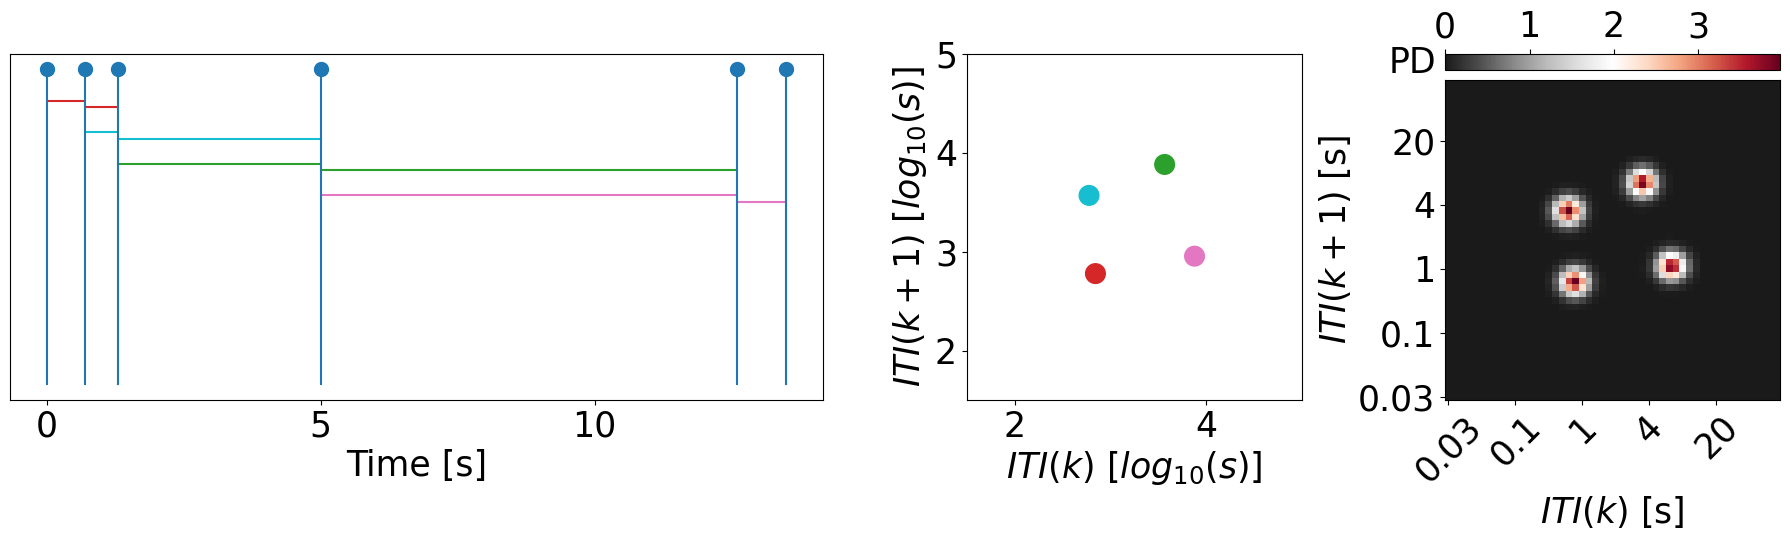

In [3]:
eps = 1e-5
BINS = 50
MIN_H = 1.5
MAX_H = 5
labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]
xx, yy = np.mgrid[MIN_H : MAX_H : BINS * 1j, MIN_H : MAX_H : BINS * 1j]
xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T

t = np.array([0, 0.7, 1.3, 5, 12.6, 13.5]) * 1000
# t = np.array([0, 0.5, 2.3, 5, 12.6, 13.5]) * 1000
dt = np.diff(t)

log_dt1, log_dt2 = np.log10(dt[:-1] + eps), np.log10(dt[1:] + eps)
xy_train  = np.vstack([log_dt1, log_dt2]).T
kde_skl = KernelDensity(bandwidth=0.1)
kde_skl.fit(xy_train)
z = np.exp(kde_skl.score_samples(xy_sample))
dt_dt = np.reshape(z, xx.shape)
fig = plt.figure(figsize=(18, 5.5), tight_layout=True)
gs = gridspec.GridSpec(1, 4)

ax0 = fig.add_subplot(gs[0, :2])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[0, 3])


ax1.scatter(log_dt1, log_dt2, s=200, color=['tab:red', 'tab:cyan', 'tab:green', 'tab:pink'])
ax1.set_xlim([1.5, 5])
ax1.set_ylim([1.5, 5])
ax1.set_ylabel(r'$ITI(k + 1)$ [$log_{10}(s)$]')
ax1.set_xlabel(r'$ITI(k)$ [$log_{10}(s)$]')
ax1.grid(0)

im = ax2.imshow(dt_dt, aspect='auto', cmap='RdGy_r')
ax2.invert_yaxis()
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_yticks(ticks)
ax2.set_yticklabels(labels)
ax2.set_ylabel(r'$ITI(k + 1)$ [s]')
ax2.set_xlabel(r'$ITI(k)$ [s]')
ax2.text(-9, 50.5, 'PD', size=25)


ax2.grid(False)
divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')

ax0.plot(t, np.ones_like(t), 'o', markersize=10, c='tab:blue')

ax0.plot([t[0], t[1]], [0.9, 0.9], c='tab:red')
ax0.plot([t[1], t[2]], [0.88, 0.88], c='tab:red')

ax0.plot([t[1], t[2]], [0.8, 0.8], c='tab:cyan')
ax0.plot([t[2], t[3]], [0.78, 0.78], c='tab:cyan')

ax0.plot([t[2], t[3]], [0.7, 0.7], c='tab:green')
ax0.plot([t[3], t[4]], [0.68, 0.68], c='tab:green')

ax0.plot([t[3], t[4]], [0.6, 0.6], c='tab:pink')
ax0.plot([t[4], t[5]], [0.58, 0.58], c='tab:pink')

ax0.plot(np.concatenate([t[:, None], t[:, None]], 1).T, np.concatenate([np.array([0, 1])[:, None] for _ in range(len(t))], 1), c='tab:blue')
ax0.grid(False)
ax0.get_yaxis().set_visible(False)
ax0.set_xticks([0, 5000, 10000])
ax0.set_xticklabels([0, 5, 10])
ax0.set_xlabel('Time [s]')

plt.tight_layout()
plt.savefig('./figures/figure_1_panel_a.pdf')

## Panel B

In [29]:
version = 'v11'
window = 21
data = loadmat(f'./data/age_model_data_{window}_days_{version}.mat')
data.keys()

x_jid = np.squeeze(data['X_all'])
y_age = np.squeeze(data['y_all'])

sorted_idx = np.argsort(y_age)

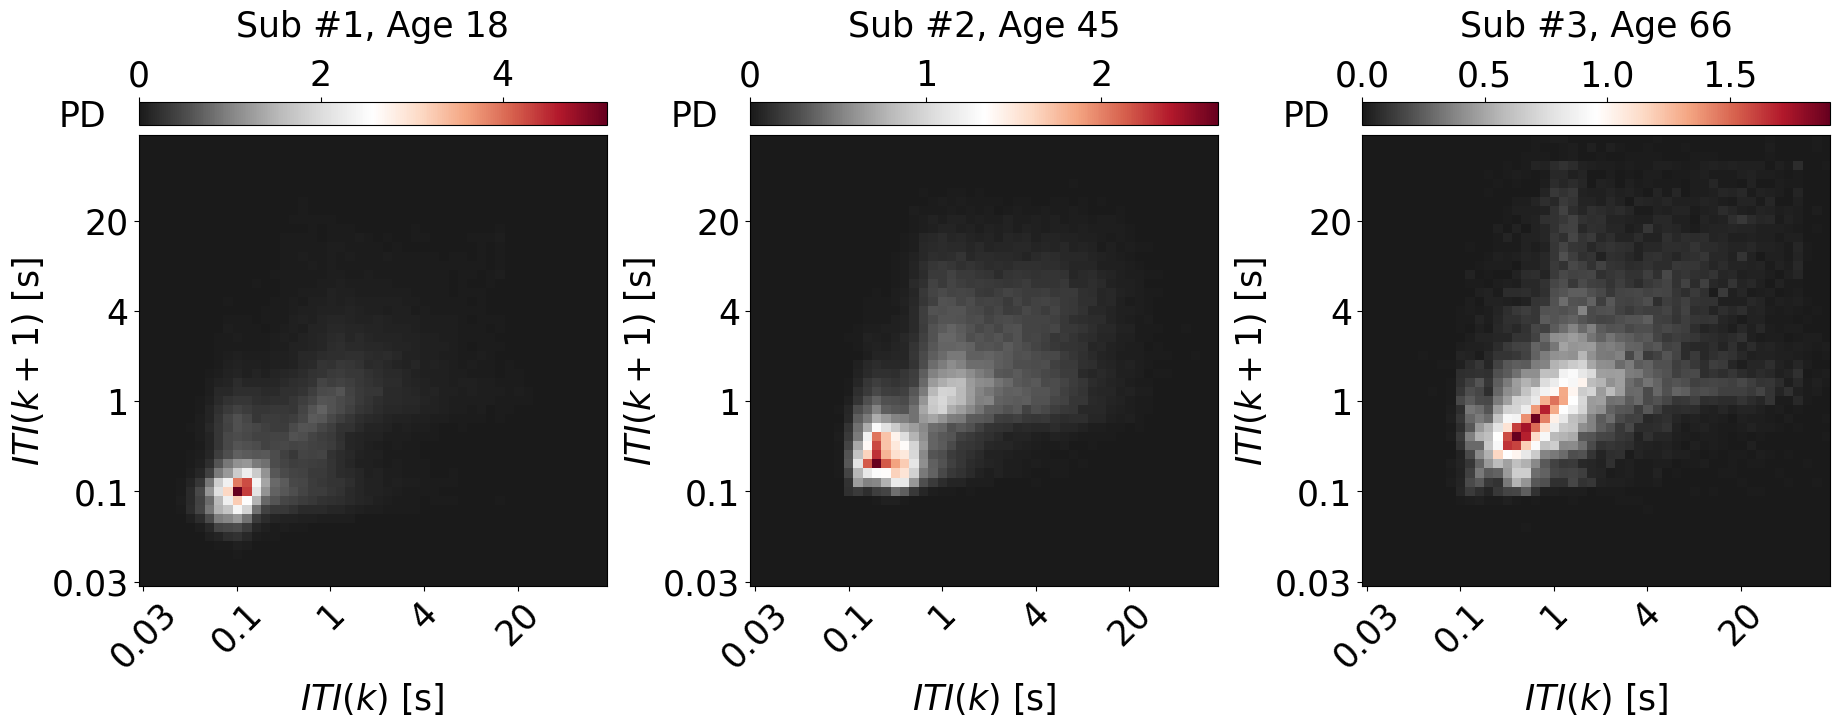

In [35]:
fig, ax = plt.subplots(1,3,figsize=(18.5, 7.5))

IDXs = [20, 1200, 3400]
for i, idx in enumerate(IDXs):
    
    plot_JID(10 ** x_jid[sorted_idx[idx]].reshape(50, 50), ax=ax[i])
    ax[i].set_title(f"Sub #{i + 1}, Age {int(y_age[sorted_idx[idx]])}", y=1.2)
    
plt.tight_layout()

plt.savefig('./figures/figure_1_panel_b.pdf')

## Panel c

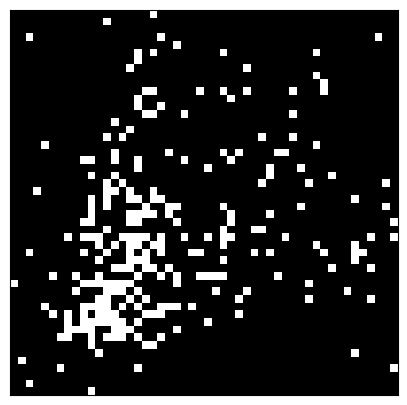

In [21]:
param_dict = pkl.load(open(f"./params/params_age_20_days_v8.pkl", "rb"))
fig, ax = plt.subplots(1, 1, figsize=(5,5))
im = ax.imshow(np.reshape(param_dict['support'][:2500], (50, 50)), aspect='auto', cmap='gray')
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('./figures/figure_1_panel_c.pdf')

## Panel d
See train_MLAGE_model.ipynb 5.1

## Panel e
See train_MLAGE_model.ipynb 7.1

# Panel f

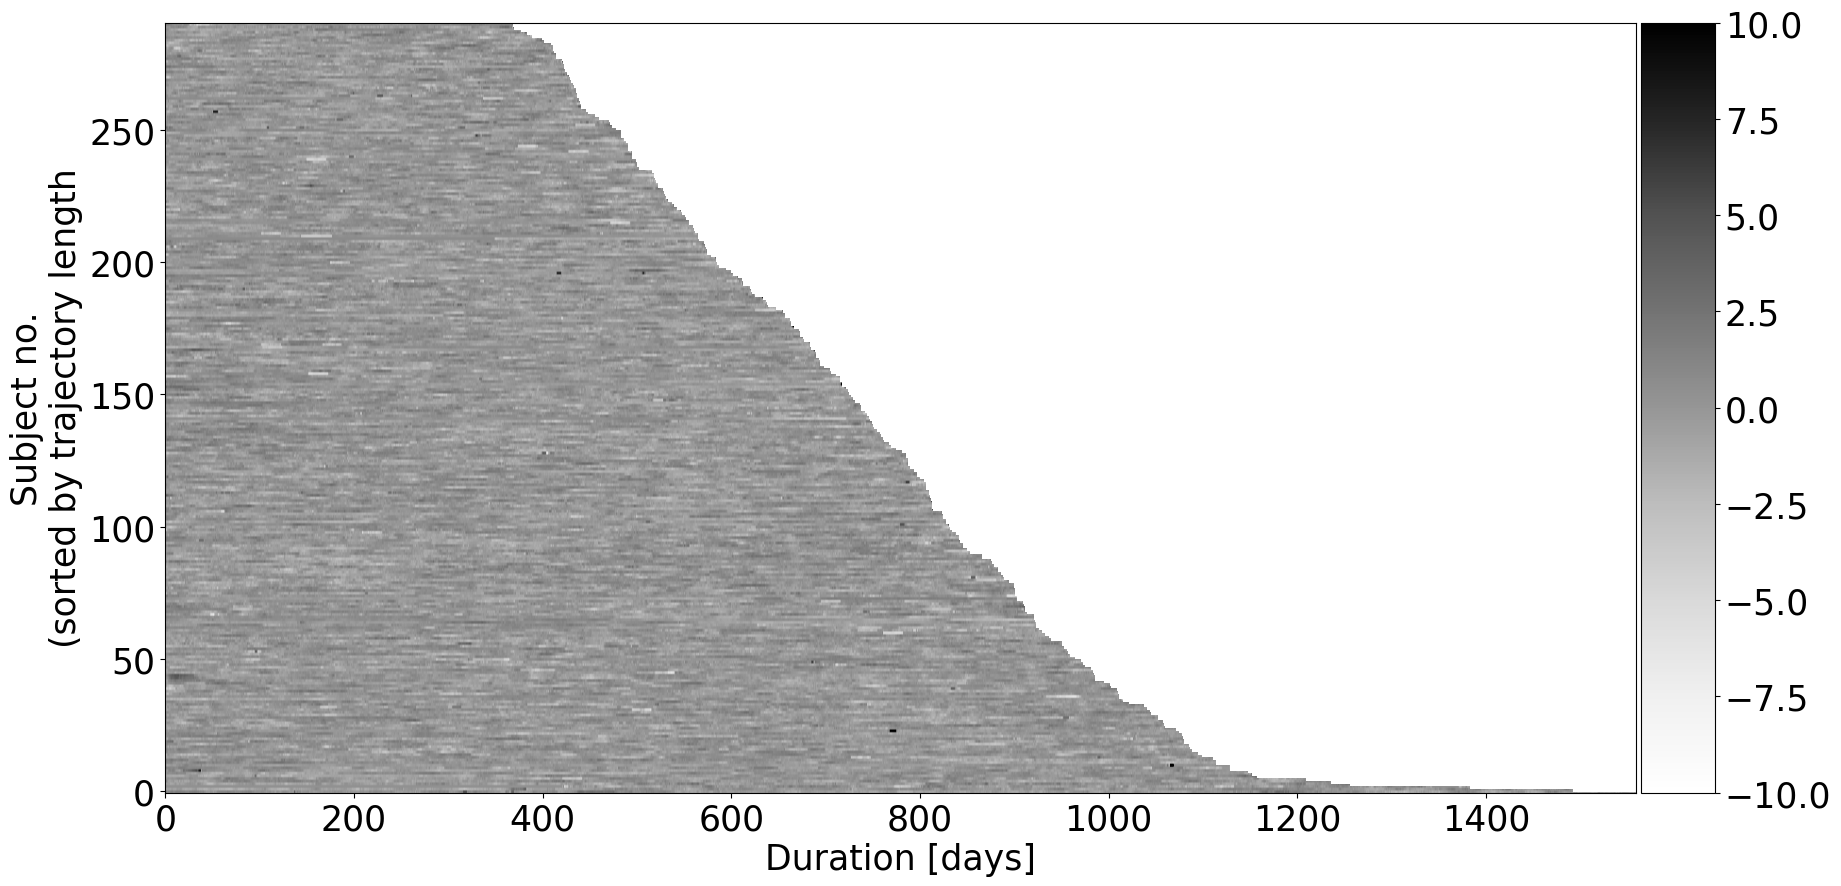

In [50]:
NORM = loadmat('all_age_pred_21d_30_11_2023.mat')
traj = np.squeeze(NORM['all_preds'])
n_sub = len(traj)
lens = [len(np.squeeze(a)) for a in traj]
idx = np.argsort(lens)

all_traj = np.zeros((n_sub, max(lens))) * np.nan

for i, t in enumerate(traj[idx]):
    _t = np.squeeze(t)
    all_traj[n_sub - i - 1, :len(_t)] = zscore(_t)

fig, ax = plt.subplots(1,1, figsize=(20, 10))
im = ax.imshow(all_traj, cmap='Greys', aspect='auto', vmin=-10, vmax=10)
ax.invert_yaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('Duration [days]')
ax.set_ylabel('Subject no.\n(sorted by trajectory length')
plt.savefig('./figures/figure_1_panel_f.pdf')

## Supplementary 2

# Figure 2

## Panel A

In [41]:
all_pids = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_pids'])
all_ages = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_ages'])
all_preds = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_preds'])
all_preds_times = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_preds_times'])
pids_for_buckets = np.squeeze(loadmat('../ML_Age_Trajectory_2023/all_buckets.mat')['pids_for_buckets'])
all_dom = np.squeeze(loadmat('../ML_Age_Trajectory_2023/all_buckets.mat')['all_dom'])
all_y = np.squeeze(loadmat('../ML_Age_Trajectory_2023/all_buckets.mat')['all_y'])

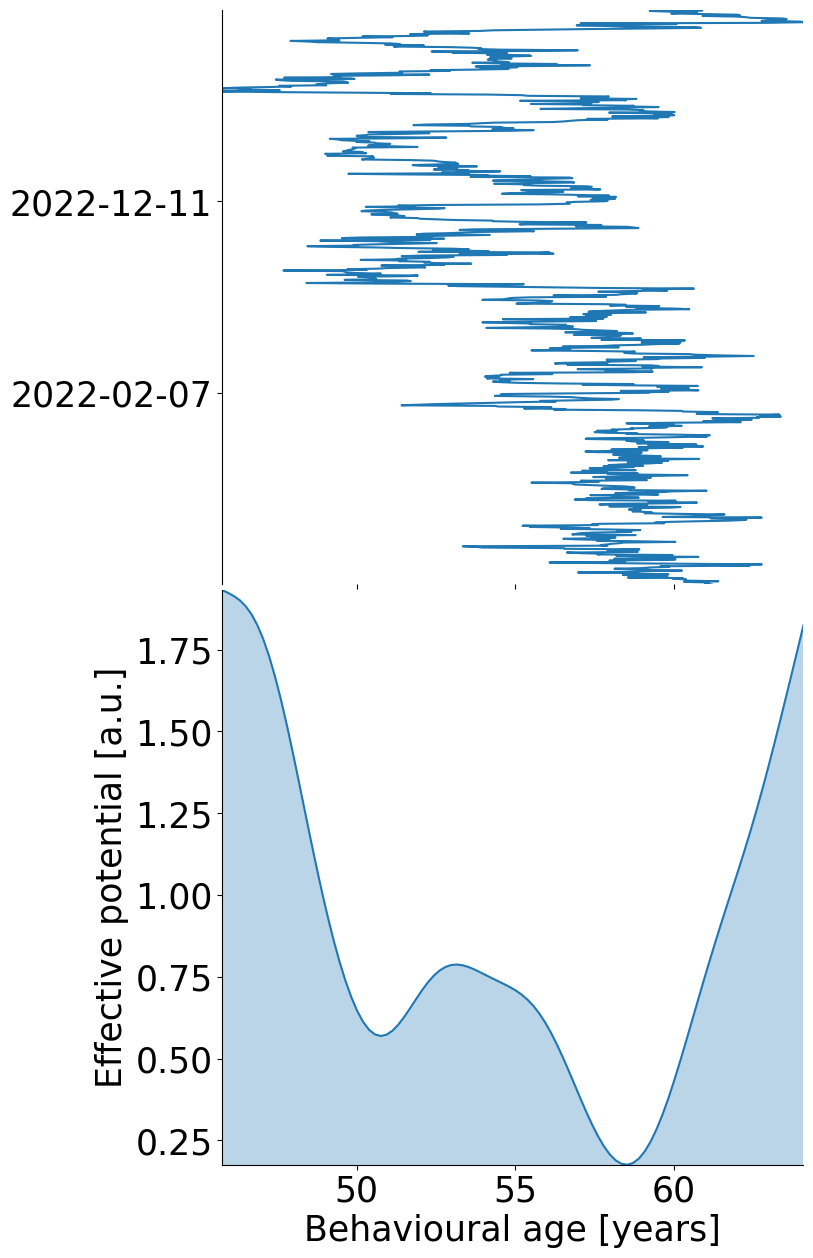

In [50]:
fig, ax = plt.subplots(2,1,figsize=(7.5, 15), sharex=True)

rel_idx = 40
IDX = np.where(np.array(all_pids) == pids_for_buckets[rel_idx][0])[0][0]

new_dom = np.squeeze(all_dom[rel_idx])
new_y = np.squeeze(all_y[rel_idx])

t_ = pd.to_datetime(np.squeeze(all_preds_times[IDX]), unit='ms')
x_ = np.squeeze(all_preds[IDX])
mu = np.nanmean(x_)
sigma = np.nanstd(x_)

ax[0].plot(x_, t_);
ax[0].invert_yaxis()
ax[0].set_ylim(t_[[0, -1]])
ax[0].set_yticks([t_[i] for i in [len(t_)//3, len(t_)//3 * 2]])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

ax[1].plot(new_dom, new_y);
ax[0].set_xlim(new_dom[[0, -1]])
ax[1].set_xlim(new_dom[[0, -1]])
ax[1].fill_between(new_dom, new_y, alpha=0.3)
ax[1].set_ylim([np.min(new_y), np.max(new_y)])

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel("Behavioural age [years]")
ax[1].set_ylabel("Effective potential [a.u.]")

plt.subplots_adjust(hspace=0.01)

plt.savefig('./figures/figure_2_panel_a.pdf')

## Panel C

In [3]:
n_unstable_points = np.squeeze(loadmat('for_figure_2.mat')['n_unstable_points'])

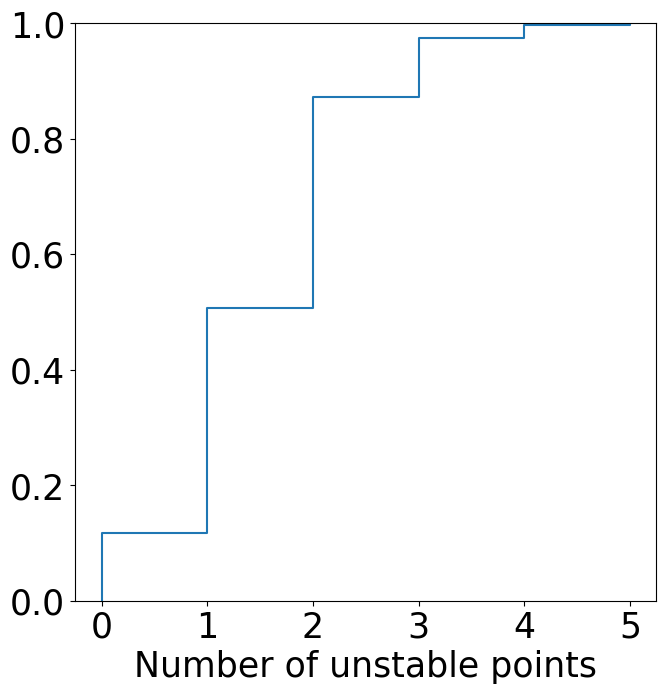

In [7]:
fig, ax = plt.subplots(1,1,figsize=(7.5, 7.5))
ax.ecdf(n_unstable_points)
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xlabel('Number of unstable points')
plt.savefig('./figures/figure_2_panel_c.pdf')

## Panel D

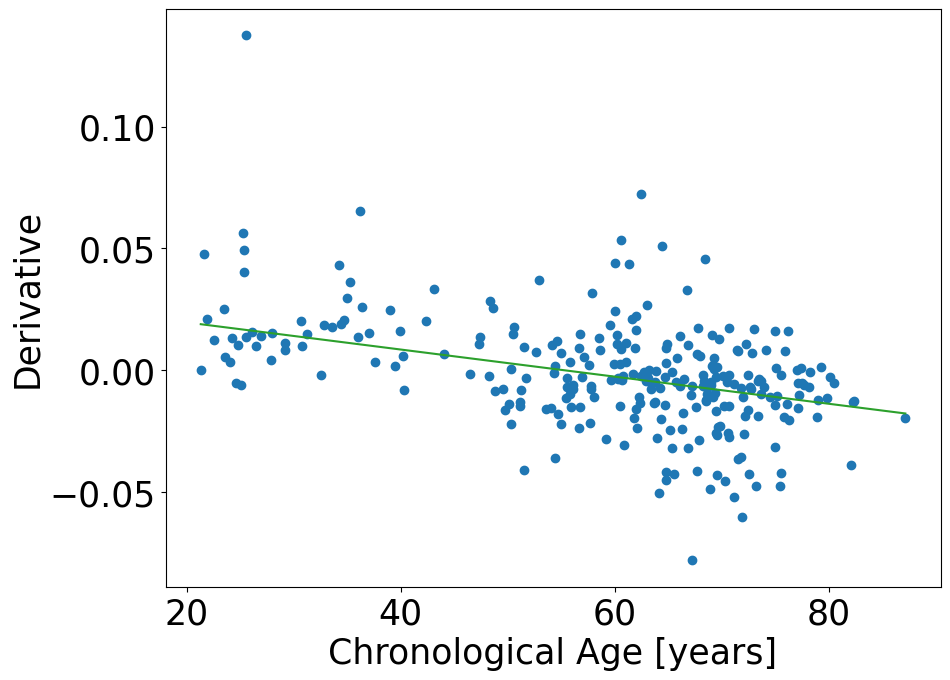

In [17]:
_adjusted2d = loadmat('for_figure_2.mat')['adjusted2d']
adjusted_data2d = np.squeeze(_adjusted2d[0][0][1]).T
adjusted_fit2d = np.squeeze(_adjusted2d[0][0][0]).T
adjusted_pval = np.squeeze(_adjusted2d[0][0][2]).flatten()[0]
adjusted_pval

fig, ax = plt.subplots(1,1,figsize=(10, 7.5))
ax.scatter(adjusted_data2d[:, 0], adjusted_data2d[:, 1])
ax.plot(adjusted_fit2d[:, 0], adjusted_fit2d[:, 1], '-', color='tab:green')
ax.set_xlabel('Chronological Age [years]')
ax.set_ylabel('Derivative')
plt.savefig('./figures/figure_2_panel_d.pdf')

# Supplementary Figure 6

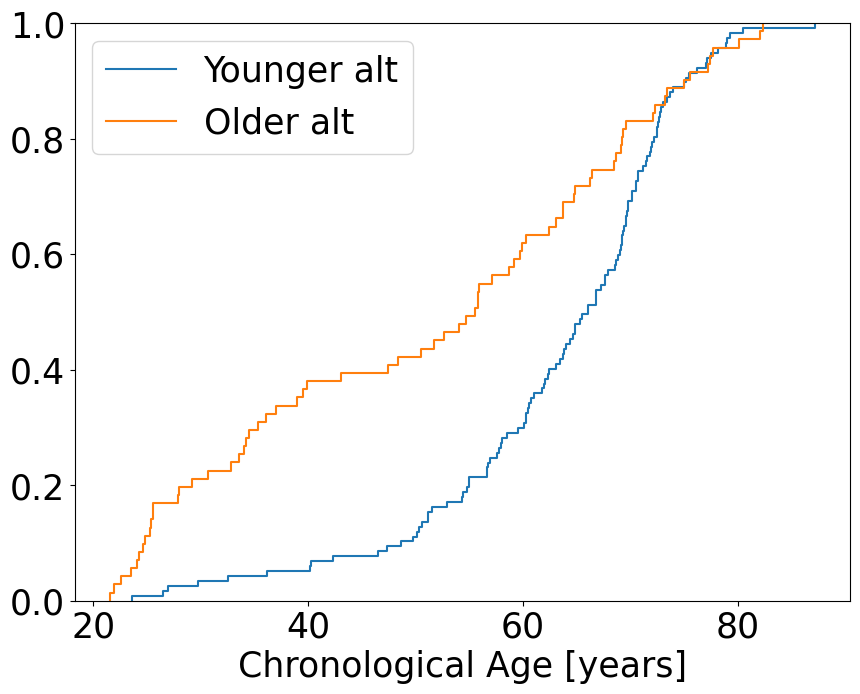

In [26]:
age = np.squeeze(loadmat('for_figure_2.mat')['age'])
idx_left = np.squeeze(loadmat('for_figure_2.mat')['idx_left'])
idx_right = np.squeeze(loadmat('for_figure_2.mat')['idx_right'])

fig, ax = plt.subplots(1,1,figsize=(10, 7.5))

ax.ecdf(age[idx_left > 0], label='Younger alt')
ax.ecdf(age[idx_right > 0], label='Older alt')
ax.legend()
ax.set_xlabel('Chronological Age [years]')
plt.savefig('./figures/supplementary_figure_6.pdf')

# Figure 3

## Panel A

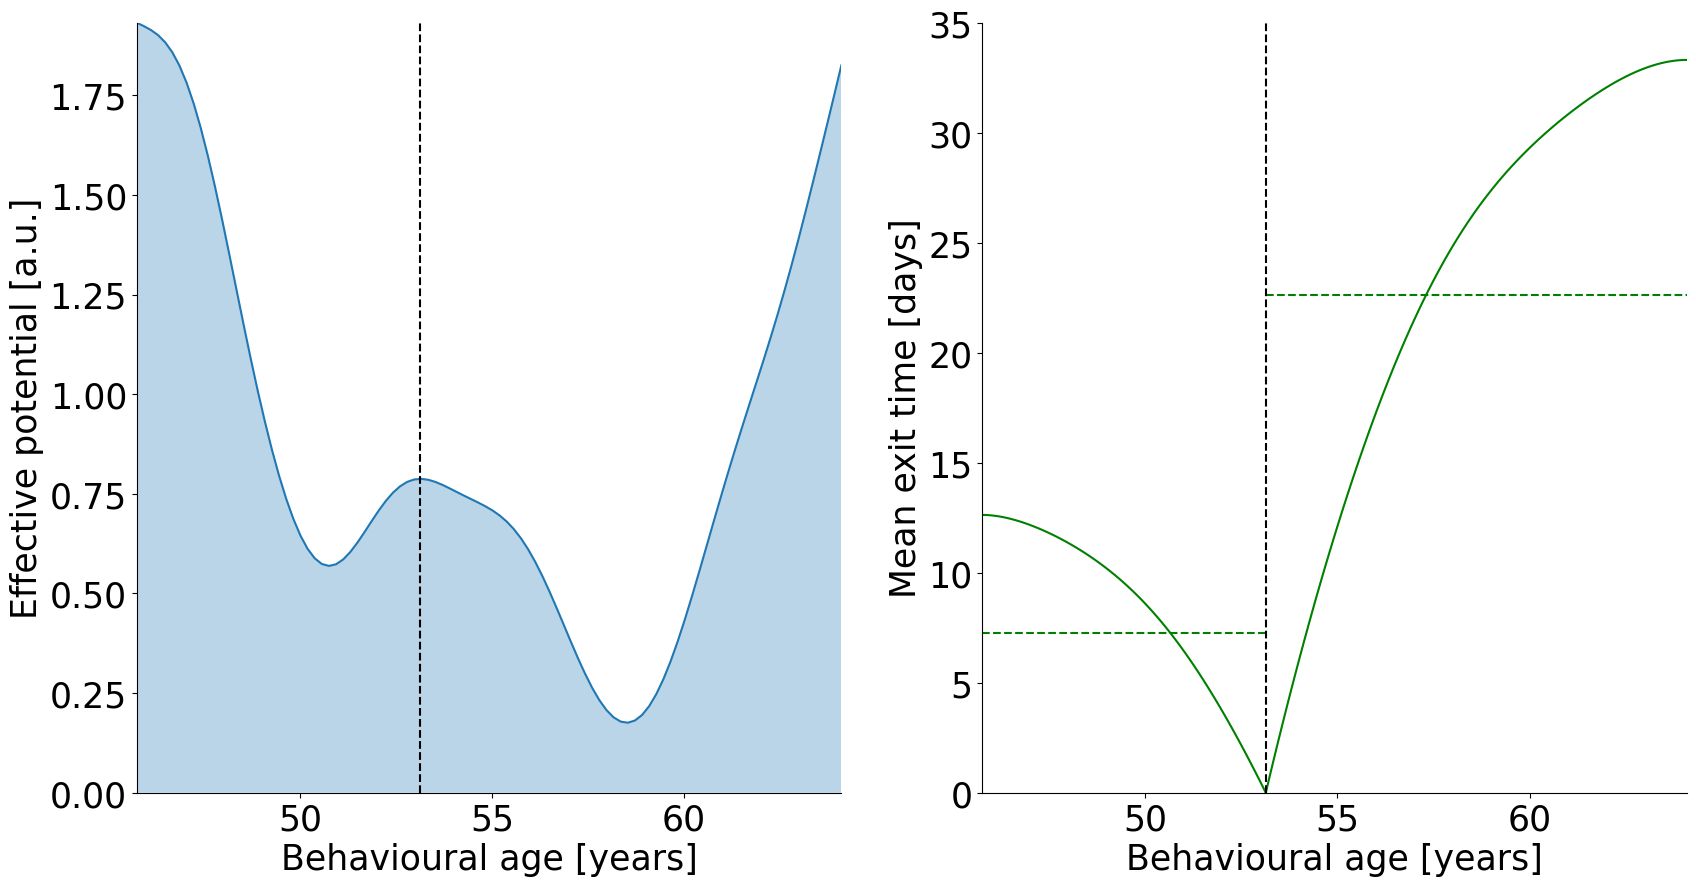

In [66]:
x = np.squeeze(loadmat('for_figures_3_4.mat')['x'])
t = np.squeeze(loadmat('for_figures_3_4.mat')['t'])
y = np.squeeze(loadmat('for_figures_3_4.mat')['y'])
mu = np.squeeze(loadmat('for_figures_3_4.mat')['MU'])
sigma = np.squeeze(loadmat('for_figures_3_4.mat')['SIGMA'])
dom = np.squeeze(loadmat('for_figures_3_4.mat')['dom']) * sigma + mu
met_T_2 = np.squeeze(loadmat('for_figures_3_4.mat')['met_T_2'])
met_T_1 = np.squeeze(loadmat('for_figures_3_4.mat')['met_T_1'])
met_WT_2 = np.squeeze(loadmat('for_figures_3_4.mat')['met_WT_2'])
met_WT_1 = np.squeeze(loadmat('for_figures_3_4.mat')['met_WT_1'])
met_dom_2 = np.squeeze(loadmat('for_figures_3_4.mat')['met_dom_2']) * sigma + mu
met_dom_1 = np.squeeze(loadmat('for_figures_3_4.mat')['met_dom_1']) * sigma + mu

fig, ax = plt.subplots(1,2,figsize=(20, 10))
ax[0].plot(dom, y);
ax[0].set_xlim(dom[[0, -1]])
ax[0].fill_between(dom, y, alpha=0.3)
ax[0].plot([met_dom_1[1]] * 2, [0, np.max(y)], '--k')
ax[0].set_ylim([0, np.max(y)])

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlabel("Behavioural age [years]")
ax[0].set_ylabel("Effective potential [a.u.]")

ax[1].plot(np.linspace(met_dom_1[0], met_dom_1[1], 100), met_T_1, '-g');
ax[1].plot(np.linspace(met_dom_2[0], met_dom_2[1], 100), met_T_2, '-g');
ax[1].plot(met_dom_1, [met_WT_1] * 2, '--g');
ax[1].plot(met_dom_2, [met_WT_2] * 2, '--g');
ax[1].plot([met_dom_1[1]] * 2, [0, 35], '--k')
ax[1].set_xlim(dom[[0, -1]])
ax[1].set_ylim([0, 35])

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel("Behavioural age [years]")
ax[1].set_ylabel("Mean exit time [days]")
plt.savefig('./figures/figure_3_panel_a.pdf')

## Panel B

# Figure 4

## Panel A

In [69]:
all_pids = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_pids'])
all_ages = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_ages'])
all_preds = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_preds'])
all_preds_times = np.squeeze(loadmat('all_age_pred_21d_30_11_2023.mat')['all_preds_times'])
all_bucktes = np.squeeze(np.array(loadmat('../ML_Age_Trajectory_2023/all_buckets.mat')['all_buckets']))
pids_for_buckets = np.squeeze(loadmat('../ML_Age_Trajectory_2023/all_buckets.mat')['pids_for_buckets'])
all_dom = np.squeeze(loadmat('../ML_Age_Trajectory_2023/all_buckets.mat')['all_dom'])
all_y = np.squeeze(loadmat('../ML_Age_Trajectory_2023/all_buckets.mat')['all_y'])

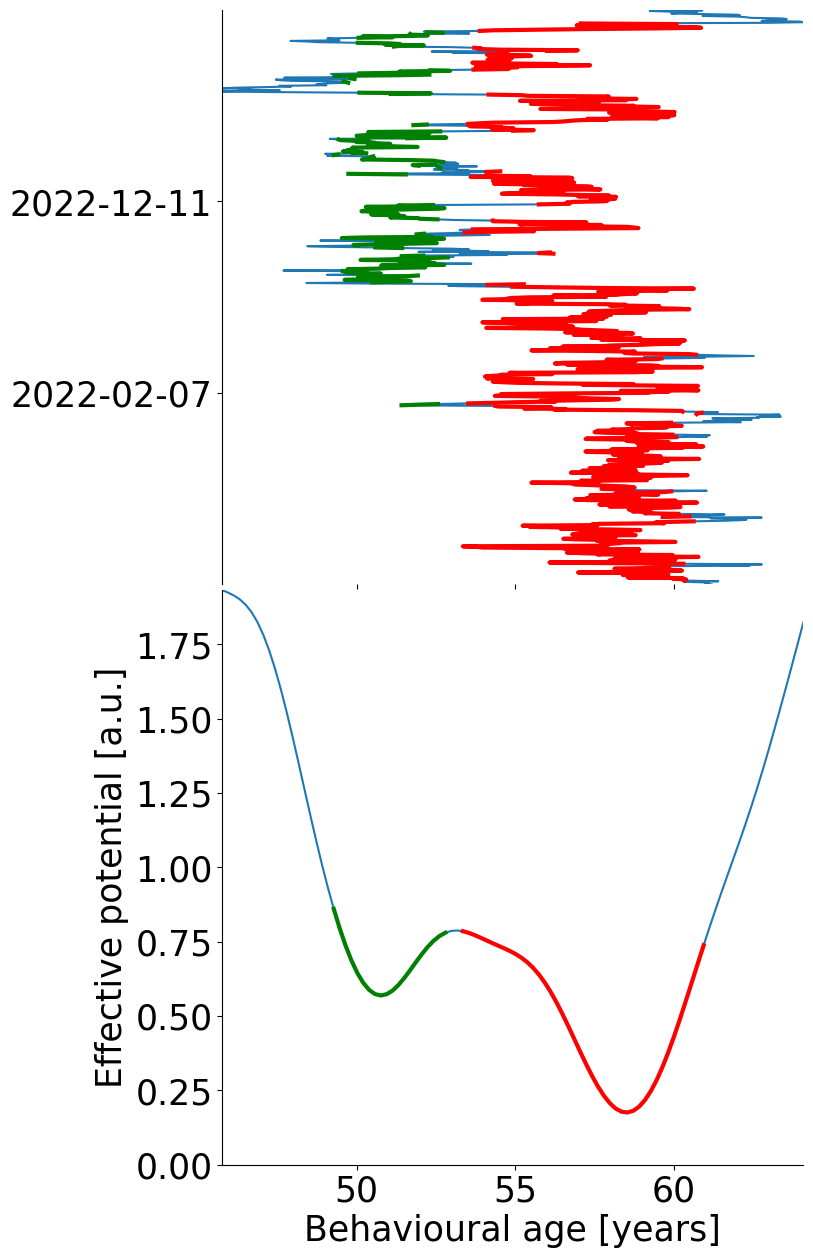

In [97]:
fig, ax = plt.subplots(2,1,figsize=(7.5, 15), sharex=True)

rel_idx = 40
IDX = np.where(np.array(all_pids) == pids_for_buckets[rel_idx][0])[0][0]

bucketL = all_bucktes[rel_idx][0][0]
bucketR = all_bucktes[rel_idx][1][0]

new_dom = np.squeeze(all_dom[rel_idx])
new_y = np.squeeze(all_y[rel_idx])

t_ = pd.to_datetime(np.squeeze(all_preds_times[IDX]), unit='ms')
x_ = np.squeeze(all_preds[IDX])
mu = np.nanmean(x_)
sigma = np.nanstd(x_)

_idxsL = np.where((x_ >= bucketL[0]) & ((x_ <= bucketL[1])))[0]
_idxsR = np.where((x_ >= bucketR[0]) & ((x_ <= bucketR[1])))[0]

ax[0].plot(x_, t_);
fL = [0] + list(np.where(np.diff(_idxsL) > 1)[0] + 1) + [len(_idxsL) - 1]
startL = fL[:-1]
endL = fL[1:]
for _s, _e in zip(startL, endL):
    ax[0].plot(x_[_idxsL[_s:_e]], t_[_idxsL[_s:_e]], 'g', linewidth=3);

fR = [0] + list(np.where(np.diff(_idxsR) > 1)[0] + 1) + [len(_idxsL) - 1]
startR = fR[:-1]
endR = fR[1:]
for _s, _e in zip(startR, endR):
    ax[0].plot(x_[_idxsR[_s:_e]], t_[_idxsR[_s:_e]], 'r', linewidth=3);
    
ax[0].invert_yaxis()
ax[0].set_ylim(t_[[0, -1]])
ax[0].set_yticks([t_[i] for i in [len(t_)//3, len(t_)//3 * 2]])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

ax[1].plot(new_dom, new_y);
ax[1].plot(new_dom[np.where((new_dom >= bucketL[0]) & ((new_dom <= bucketL[1])))[0]], 
           new_y[np.where((new_dom >= bucketL[0]) & ((new_dom <= bucketL[1])))[0]], 'g', linewidth=3);
ax[1].plot(new_dom[np.where((new_dom >= bucketR[0]) & ((new_dom <= bucketR[1])))[0]], 
           new_y[np.where((new_dom >= bucketR[0]) & ((new_dom <= bucketR[1])))[0]], 'r', linewidth=3);
ax[0].set_xlim(new_dom[[0, -1]])
ax[1].set_xlim(new_dom[[0, -1]])
# ax[1].fill_between(new_dom, new_y, alpha=0.3)
ax[1].set_ylim([0, np.max(new_y)])

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel("Behavioural age [years]")
ax[1].set_ylabel("Effective potential [a.u.]")

plt.subplots_adjust(hspace=0.01)

plt.savefig('./figures/figure_4_panel_a.pdf')

# Figure 3

## Panel  B

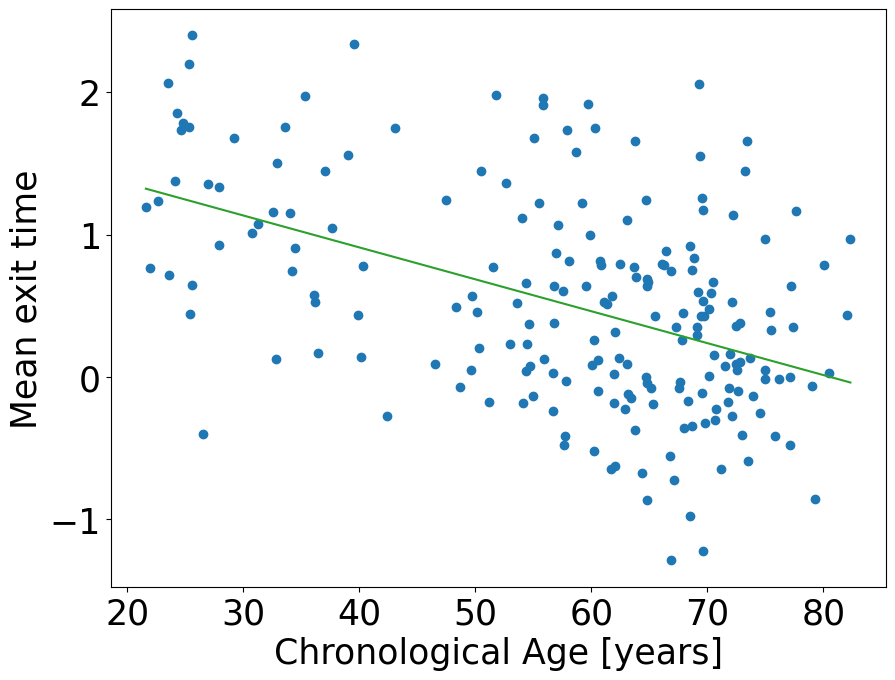

In [99]:
_adjusted3b = loadmat('for_figure_3_bc.mat')['adjusted3b']
adjusted_data3b = np.squeeze(_adjusted3b[0][0][1]).T
adjusted_fit3b = np.squeeze(_adjusted3b[0][0][0]).T
# adjusted_pval = np.squeeze(_adjusted2d[0][0][2]).flatten()[0]
# adjusted_pval

fig, ax = plt.subplots(1,1,figsize=(10, 7.5))
ax.scatter(adjusted_data3b[:, 0], adjusted_data3b[:, 1])
ax.plot(adjusted_fit3b[:, 0], adjusted_fit3b[:, 1], '-', color='tab:green')
ax.set_xlabel('Chronological Age [years]')
ax.set_ylabel('Mean exit time')
plt.savefig('./figures/figure_3_panel_b.pdf')

## Panel C

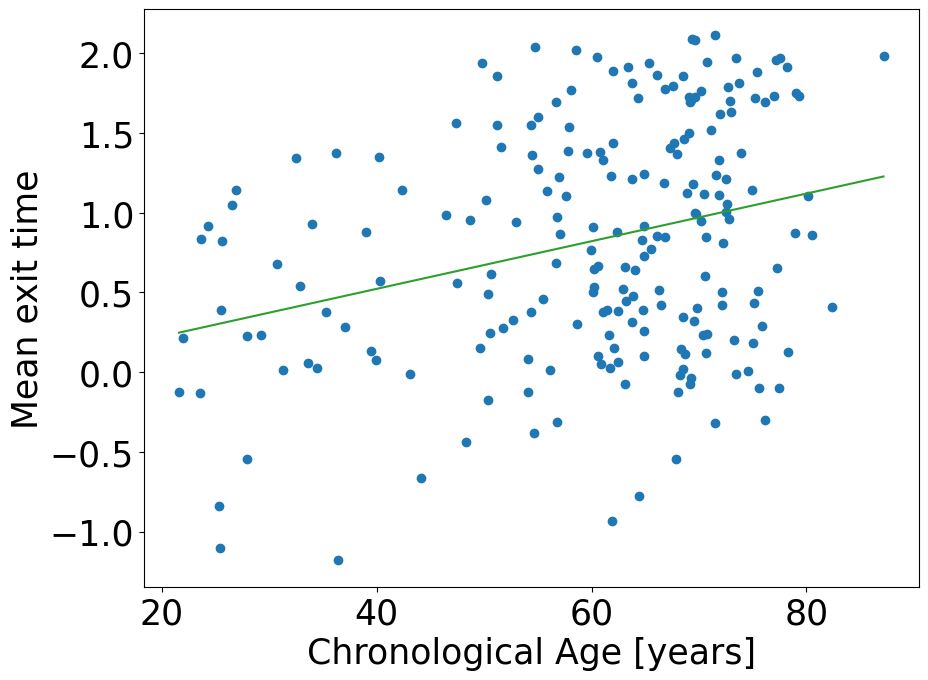

In [100]:
_adjusted3c = loadmat('for_figure_3_bc.mat')['adjusted3c']
adjusted_data3c = np.squeeze(_adjusted3c[0][0][1]).T
adjusted_fit3c = np.squeeze(_adjusted3c[0][0][0]).T
# adjusted_pval = np.squeeze(_adjusted2d[0][0][2]).flatten()[0]
# adjusted_pval

fig, ax = plt.subplots(1,1,figsize=(10, 7.5))
ax.scatter(adjusted_data3c[:, 0], adjusted_data3c[:, 1])
ax.plot(adjusted_fit3c[:, 0], adjusted_fit3c[:, 1], '-', color='tab:green')
ax.set_xlabel('Chronological Age [years]')
ax.set_ylabel('Mean exit time')
plt.savefig('./figures/figure_3_panel_c.pdf')

# Supplementary 7

## Panel B

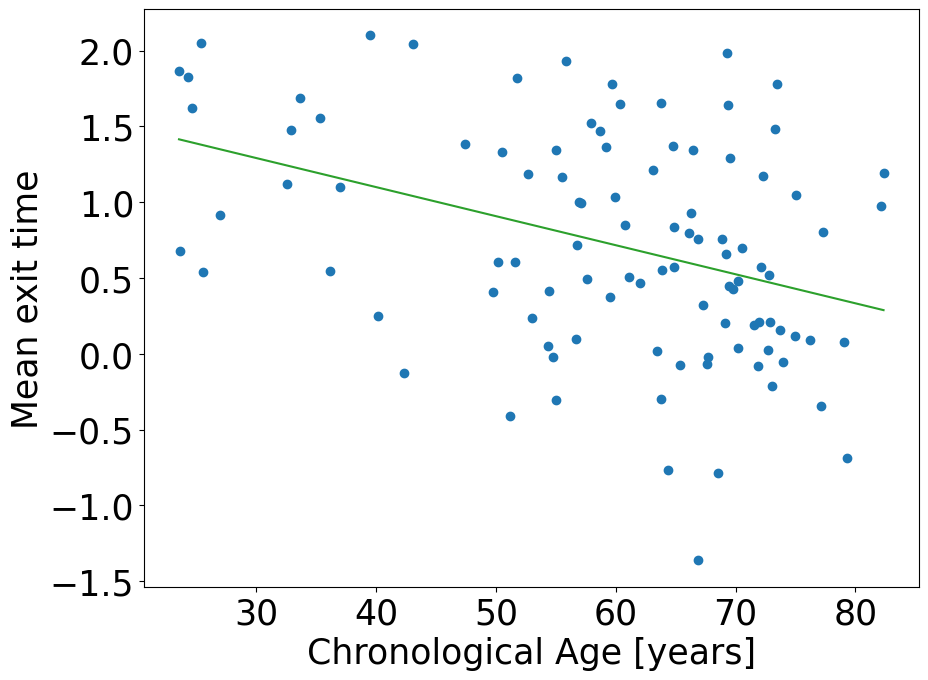

In [101]:
_adjusted7b = loadmat('for_figure_3_bc.mat')['adjusted7b']
adjusted_data7b = np.squeeze(_adjusted7b[0][0][1]).T
adjusted_fit7b = np.squeeze(_adjusted7b[0][0][0]).T
# adjusted_pval = np.squeeze(_adjusted2d[0][0][2]).flatten()[0]
# adjusted_pval

fig, ax = plt.subplots(1,1,figsize=(10, 7.5))
ax.scatter(adjusted_data7b[:, 0], adjusted_data7b[:, 1])
ax.plot(adjusted_fit7b[:, 0], adjusted_fit7b[:, 1], '-', color='tab:green')
ax.set_xlabel('Chronological Age [years]')
ax.set_ylabel('Mean exit time')
plt.savefig('./figures/supplementary_figure_7_panel_b.pdf')

## Panel C

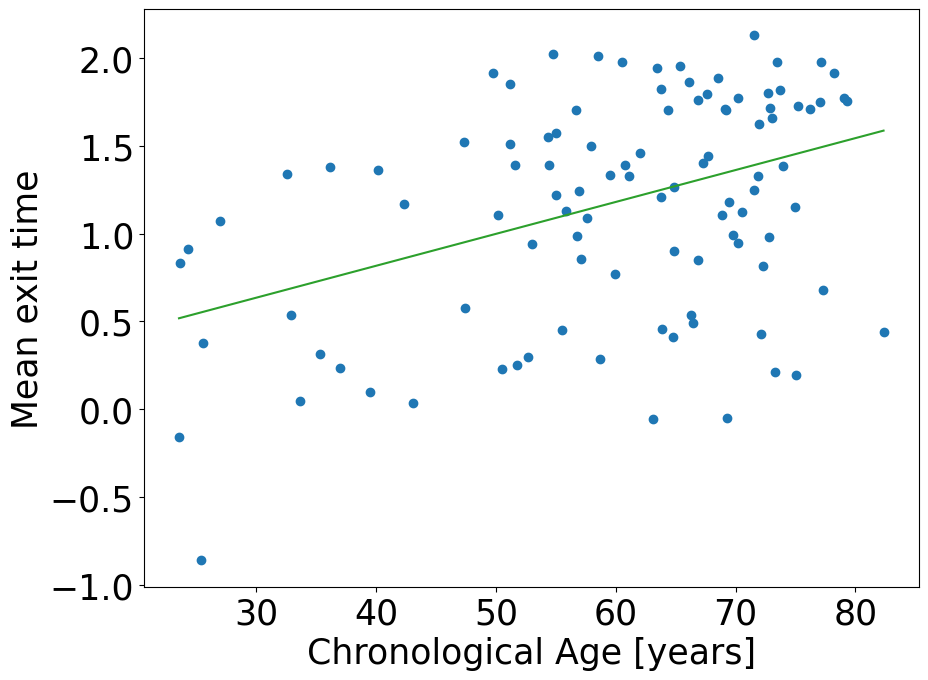

In [102]:
_adjusted7c = loadmat('for_figure_3_bc.mat')['adjusted7c']
adjusted_data7c = np.squeeze(_adjusted7c[0][0][1]).T
adjusted_fit7c = np.squeeze(_adjusted7c[0][0][0]).T
# adjusted_pval = np.squeeze(_adjusted2d[0][0][2]).flatten()[0]
# adjusted_pval

fig, ax = plt.subplots(1,1,figsize=(10, 7.5))
ax.scatter(adjusted_data7c[:, 0], adjusted_data7c[:, 1])
ax.plot(adjusted_fit7c[:, 0], adjusted_fit7c[:, 1], '-', color='tab:green')
ax.set_xlabel('Chronological Age [years]')
ax.set_ylabel('Mean exit time')
plt.savefig('./figures/supplementary_figure_7_panel_c.pdf')